# Install Requirements

In [ ]:
!pip install -Uq transformers datasets sentencepiece sentence-transformers accelerate parsivar evaluate

# Restart Session
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8

# Import libraries and ready the environment

In [1]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
    pipeline
)

import torch

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sentence_transformers import SentenceTransformer, util
from collections import Counter
from parsivar import Normalizer
from pprint import pprint
# import seaborn as sns

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cuda')

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores available: {num_cores}")

Number of CPU cores available: 2


# Load and Inspect Dataset

In [5]:
ds = load_dataset("SajjadAyoubi/persian_qa")
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 9008
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 930
    })
})

## Inspect Data

In [6]:
ds['train'][0]

{'id': 1,
 'title': 'شرکت فولاد مبارکه اصفهان',
 'context': 'شرکت فولاد مبارکۀ اصفهان، بزرگ\u200cترین واحد صنعتی خصوصی در ایران و بزرگ\u200cترین مجتمع تولید فولاد در کشور ایران است، که در شرق شهر مبارکه قرار دارد. فولاد مبارکه هم\u200cاکنون محرک بسیاری از صنایع بالادستی و پایین\u200cدستی است. فولاد مبارکه در ۱۱ دوره جایزۀ ملی تعالی سازمانی و ۶ دوره جایزۀ شرکت دانشی در کشور رتبۀ نخست را بدست آورده\u200cاست و همچنین این شرکت در سال ۱۳۹۱ برای نخستین\u200cبار به عنوان تنها شرکت ایرانی با کسب امتیاز ۶۵۴ تندیس زرین جایزۀ ملی تعالی سازمانی را از آن خود کند. شرکت فولاد مبارکۀ اصفهان در ۲۳ دی ماه ۱۳۷۱ احداث شد و اکنون بزرگ\u200cترین واحدهای صنعتی و بزرگترین مجتمع تولید فولاد در ایران است. این شرکت در زمینی به مساحت ۳۵ کیلومتر مربع در نزدیکی شهر مبارکه و در ۷۵ کیلومتری جنوب غربی شهر اصفهان واقع شده\u200cاست. مصرف آب این کارخانه در کمترین میزان خود، ۱٫۵٪ از دبی زاینده\u200cرود برابر سالانه ۲۳ میلیون متر مکعب در سال است و خود یکی از عوامل کم\u200cآبی زاینده\u200cرود شناخته می\u200cشود.',
 'questio

In [7]:
print("Number of questions with no answers in train dataset:")
print(len(ds.filter(lambda x: len(x['answers']['text']) == 0)['train']), '\n')

print("Number of questions with no answers in validation dataset:")
print(len(ds.filter(lambda x: len(x['answers']['text']) == 0)['validation']))

Number of questions with no answers in train dataset:
2702 

Number of questions with no answers in validation dataset:
279


In [8]:
print("Number of answers in train dataset with answers length more than 1:")
print(len(ds.filter(lambda x: len(x['answers']['text']) > 1)['train']), '\n')

print("Number of answers in validation dataset with answers length more than 1:")
print(len(ds.filter(lambda x: len(x['answers']['text']) > 1)['validation']), '\n')

Number of answers in train dataset with answers length more than 1:
0 

Number of answers in validation dataset with answers length more than 1:
651 



In [9]:
max_len_train = max((len(ans) for item in ds['train'] for ans in item['answers']['text']), default=0)
max_len_validation = max((len(ans) for item in ds['validation'] for ans in item['answers']['text']), default=0)

print("Max length of answers in train dataset:", max_len_train)
print("Max length of answers in validation dataset:", max_len_validation)

Max length of answers in train dataset: 535
Max length of answers in validation dataset: 188


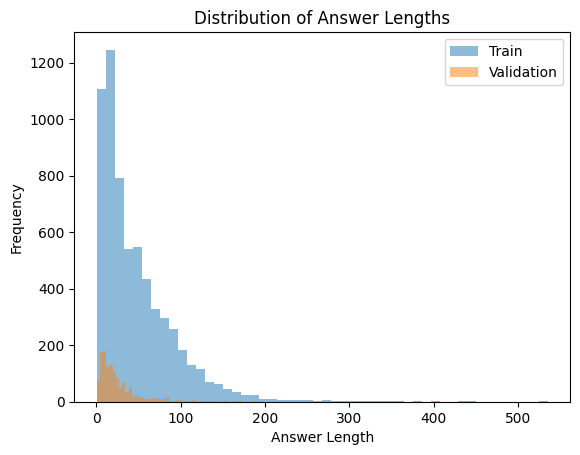

In [10]:
# prompt: plot based on the length of texts in answers field

train_answer_lens = []
for item in ds['train']:
    if len(item['answers']['text']) > 0:
        for ans in item['answers']['text']:
            train_answer_lens.append(len(ans))

validation_answer_lens = []
for item in ds['validation']:
    if len(item['answers']['text']) > 0:
        for ans in item['answers']['text']:
            validation_answer_lens.append(len(ans))

plt.hist(train_answer_lens, bins=50, alpha=0.5, label='Train')
plt.hist(validation_answer_lens, bins=50, alpha=0.5, label='Validation')
plt.xlabel('Answer Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Distribution of Answer Lengths')
plt.show()

# Evaluate Models

## Ready the evaluation data

In [ ]:
EVALUATION_COUNT = 100

In [ ]:
eval_data = ds['validation'].select(range(EVALUATION_COUNT))

## Utils

In [ ]:
def normalize_answer(text):
    # Step 0: Remove any space from beginning and end of sentence
    text = text.strip()

    # Step 1: Use Parsivar to normalize data
    normalizer = Normalizer()
    text = normalizer.normalize(text)

    # Step 2: Remove letters repeated more than twice
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Step 3: Remove any Arabic diacritics from the text
    arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(arabic_diacritics, '', text)

    # Step 4: Remove the hashtag sign (“#”) from the text while keeping the information included in the hashtags
    text = re.sub(r'#', ' ', text)
    text = text.replace('_', ' ')

    # Step 5: Last normalization
    text = normalizer.normalize(text)

    return text

In [ ]:
def get_tokens(text):
    if not text: return []
    return normalize_answer(text).split()

In [ ]:
def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        return int(gold_toks == pred_toks)

    common = Counter(gold_toks) & Counter(pred_toks)
    num_same = sum(common.values())
    if num_same == 0:
        return 0

    precision = num_same / len(pred_toks)
    recall = num_same / len(gold_toks)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

def compute_similarity_score(predicted_answer, answers, similarity_model):
    predicted_embedding = similarity_model.encode(predicted_answer, convert_to_tensor=True)
    answer_embeddings = similarity_model.encode(answers, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(predicted_embedding, answer_embeddings)
    similarity_score = torch.max(cosine_scores).item()
    return similarity_score

In [ ]:
def evaluate_model(model_checkpoint, eval_data, handle_impossible_answer, device):
    qa_pipeline = pipeline("question-answering", model=model_checkpoint, device=device)
    similarity_model = SentenceTransformer('all-MiniLM-L6-v2')

    exact_match = 0
    f1_score = 0
    total = 0
    similarity_scores = []

    for entry in tqdm(eval_data, desc=f"Evaluating {model_checkpoint}", unit="sample"):
        context = entry['context']
        question = entry['question']
        answers = entry['answers']['text']

        result = qa_pipeline(
            question=question,
            context=context,
            handle_impossible_answer=handle_impossible_answer
        )
        predicted_answer = result['answer']

        # Evaluate exact match, F1 score and similarity
        if len(answers) == 0 and predicted_answer == '':
            exact_match += 1.0
            f1_score += 1.0
            similarity_score = 1.0
        elif len(answers) == 0 or predicted_answer == '':
            similarity_score = 0.0
        else:
            exact_match += max(compute_exact(answer, predicted_answer) for answer in answers)
            f1_score += max(compute_f1(answer, predicted_answer) for answer in answers)
            similarity_score = min(compute_similarity_score(predicted_answer, answers, similarity_model), 1.0)

        similarity_scores.append(similarity_score)

        total += 1

    exact_match = exact_match / total
    f1_score = f1_score / total
    average_similarity = sum(similarity_scores) / len(similarity_scores)

    return {"exact_match": exact_match, "f1_score": f1_score, "average_similarity": average_similarity}

## pedramyazdipoor/persian_xlm_roberta_large

In [ ]:
roberta_checkpoint = "pedramyazdipoor/persian_xlm_roberta_large"
roberta_results = evaluate_model(roberta_checkpoint, eval_data, True, device)

Evaluating pedramyazdipoor/persian_xlm_roberta_large:  95%|█████████▌| 95/100 [07:16<00:24,  4.86s/sample]

In [ ]:
from pprint import pprint

print("Final result of pedramyazdipoor/persian_xlm_roberta_large model:")
pprint(roberta_results)

Final result of pedramyazdipoor/persian_xlm_roberta_large model:
{'average_similarity': 0.826834112405777,
 'exact_match': 0.59,
 'f1_score': 0.7573513594248885}


## pedramyazdipoor/parsbert_question_answering_PQuAD

In [ ]:
parsbert_checkpoint = "pedramyazdipoor/parsbert_question_answering_PQuAD"
parsbert_results = evaluate_model(parsbert_checkpoint, eval_data, True, device)

Some weights of the model checkpoint at pedramyazdipoor/parsbert_question_answering_PQuAD were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at pedramyazdipoor/parsbert_question_answering_PQuAD and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be 

{'exact_match': 0.0,
 'f1_score': 0.03336870233309862,
 'average_similarity': 0.43789067059755327}

In [ ]:
from pprint import pprint

print("Final result of pedramyazdipoor/parsbert_question_answering_PQuAD model:")
pprint(parsbert_results)

Final result of pedramyazdipoor/parsbert_question_answering_PQuAD model:
{'average_similarity': 0.43789067059755327,
 'exact_match': 0.0,
 'f1_score': 0.03336870233309862}


# Train Models

Models under analysis are:

*   pedramyazdipoor/persian_xlm_roberta_large
*   pedramyazdipoor/parsbert_question_answering_PQuAD



## Utils

### Dataset

In [11]:
def prepare_train_features(examples, tokenizer):
    questions = [q.strip() for q in examples["question"]]

    tokenized_examples = tokenizer(
        questions,
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
    )

    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_examples.pop("offset_mapping")
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answer = examples["answers"][sample_index]

        # If no answers are given, set the cls_index as answer.
        if len(answer["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answer["answer_start"][0]
            end_char = start_char + len(answer["text"][0])

            # Start and End token index of the current span in the text.
            token_start_index = next(idx for idx, seq_id in enumerate(sequence_ids) if seq_id == 1)
            token_end_index = next(idx for idx in range(len(sequence_ids)-1, -1, -1) if sequence_ids[idx] == 1)

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)

                while token_end_index >= 0 and offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [12]:
def prepare_validation_features(examples, tokenizer):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

### Evaluation

In [13]:
import unicodedata
import string

DISCARD = [
    # "(laughter)" in Farsi
    "(خنده)",
    # ASCII
    "!",
    '"',
    "#",
    "&",
    "'",
    "(",
    ")",
    ",",
    "-",
    ".",
    ":",
    ";",
    # Unicode punctuation?
    "–",
    "“",
    "”",
    "…",
    "؟",
    "،",
    "؛",
    "ـ",
    # Unicode whitespace?
    "ً",
    "ٌ",
    "َ",
    "ُ",
    "ِ",
    "ّ",
    "ْ",
    "ٔ",
    # Other
    "«",
    "»",
    "?",
    '⁇',
    ",",
    ">",
    "<"
]

REPLACEMENTS = {
    "أ": "ا",
    "ۀ": "ە",
    "ك": "ک",
    "ي": "ی",
    "ى": "ی",
    "ﯽ": "ی",
    "ﻮ": "و",
    "ے": "ی",
    "ﺒ": "ب",
    "ﻢ": "ﻡ",
    "٬": " ",
    "ە": "ه",
}


def _normalize(text: str) -> str | None:
    # Remove hashtags - they are not being read in Farsi CV
    text = " ".join(w for w in text.split() if not w.startswith("#"))

    # Replace selected characters with others
    for lhs, rhs in REPLACEMENTS.items():
        text = text.replace(lhs, rhs)

    # Replace selected characters with empty strings
    for tok in DISCARD:
        text = text.replace(tok, "")

    # Unify the symbols that have the same meaning but different Unicode representation.
    text = unicodedata.normalize("NFKC", text)

    # Remove hamza's that were not merged with any letter by NFKC.
    text = text.replace("ء", "")

    # Remove double whitespace etc.
    return " ".join(t for t in text.split() if t)

In [14]:
def normalize_answer(text):
    # Step 0: Remove any space from beginning and end of sentence
    text = text.strip()

    # Step 1: Use Parsivar to normalize data
    normalizer = Normalizer()
    text = normalizer.normalize(text)

    # Step 2: Remove letters repeated more than twice
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Step 3: Remove any Arabic diacritics from the text
    arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(arabic_diacritics, '', text)

    # Step 4: Remove the hashtag sign (“#”) from the text while keeping the information included in the hashtags
    text = re.sub(r'#', ' ', text)
    text = text.replace('_', ' ')

    text = _normalize(text)

    # Step 5: Last normalization
    text = normalizer.normalize(text)

    return text

In [15]:
def get_tokens(text):
    if not text: return []
    return normalize_answer(text).split()

In [16]:
def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        return int(gold_toks == pred_toks)

    common = Counter(gold_toks) & Counter(pred_toks)
    num_same = sum(common.values())
    if num_same == 0:
        return 0

    precision = num_same / len(pred_toks)
    recall = num_same / len(gold_toks)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

def compute_similarity_score(predicted_answer, answers, similarity_model):
    predicted_embedding = similarity_model.encode(predicted_answer, convert_to_tensor=True)
    answer_embeddings = similarity_model.encode(answers, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(predicted_embedding, answer_embeddings)
    similarity_score = torch.max(cosine_scores).item()
    return similarity_score

In [17]:
def evaluate_model_pipeline_judge(model, tokenizer, eval_data, handle_impossible_answer, device):
    qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer, device=device)
    similarity_model = SentenceTransformer('all-MiniLM-L6-v2')

    similarity_scores = []

    for entry in tqdm(eval_data, desc=f"Evaluating...", unit="sample"):
        context = entry['context']
        question = entry['question']
        answers = entry['answers']['text']

        result = qa_pipeline(
            question=question,
            context=context,
            handle_impossible_answer=handle_impossible_answer
        )
        predicted_answer = result['answer']

        # Evaluate exact match, F1 score and similarity
        if len(answers) == 0 and predicted_answer == '':
            similarity_score = 1.0
        elif len(answers) == 0 or predicted_answer == '':
            similarity_score = 0.0
        else:
            similarity_score = min(compute_similarity_score(predicted_answer, answers, similarity_model), 1.0)

        similarity_scores.append(similarity_score)

    average_similarity = sum(similarity_scores) / len(similarity_scores)

    return {"judge_similarity": average_similarity * 100}

In [18]:
import collections
import numpy as np
from tqdm.auto import tqdm
import evaluate

squad_v2_metric = evaluate.load("squad_v2")

def compute_metrics(start_logits, end_logits, features, examples, n_best=20, max_answer_length=100, null_score_diff_threshold=0.0):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    # Prepare the necessary inputs for compute_predictions_logits
    all_predictions = []
    all_nbest_json = []
    scores_diff_json = []

    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if not(0 <= end_index < len(offsets)) or \
                     not(0 <= start_index < len(offsets)) or offsets[start_index]\
                      is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Add the null answer
        answers.append({"text": "", "logit_score": start_logit[0] + end_logit[0]})

        # Sort answers by score
        answers = sorted(answers, key=lambda x: x["logit_score"], reverse=True)

        # Get the best non-null answer
        best_non_null_answer = next((answer for answer in answers if answer["text"]), None)

        # Compute the difference between best non-null answer and null answer scores
        score_diff = best_non_null_answer["logit_score"] - start_logit[0] - end_logit[0] if best_non_null_answer else float("-inf")
        scores_diff_json.append(score_diff)

        # Predict null if the score difference is below the threshold
        if score_diff > null_score_diff_threshold:
            all_predictions.append(
                {"id": str(example_id), "prediction_text": normalize_answer(best_non_null_answer["text"].strip()), "no_answer_probability": 0.0}
            )
        else:
            all_predictions.append({"id": str(example_id), "prediction_text": "", "no_answer_probability": 1.0})

    theoretical_answers = [
        {"id": str(ex["id"]),
        "answers": {
            'text': [normalize_answer(text.strip()) for text in ex["answers"]["text"]],
            'answer_start': ex["answers"]["answer_start"]}
        } for ex in examples]
    return squad_v2_metric.compute(predictions=all_predictions, references=theoretical_answers), all_predictions, theoretical_answers, scores_diff_json

In [19]:
def evaluate_model(val_dataset, original_data, trainer):
    predictions, _, _ = trainer.predict(val_dataset)
    start_logits, end_logits = predictions
    return compute_metrics(start_logits, end_logits, val_dataset, original_data)

## Train pedramyazdipoor/persian_xlm_roberta_large

### Hyperparameters

In [20]:
roberta_checkpoint = "pedramyazdipoor/persian_xlm_roberta_large"
max_length = 512 # The maximum length of a feature (question and context)
doc_stride = 256 # The authorized overlap between two part of the context when splitting it is needed.
batch_size = 4 # Due to limitations of google colab
lr = 3e-5
n_epochs = 2
weight_decay = 0.01
warmup_ratio = 0.1
gradient_accumulation_steps = 8 # Makes the effective batch size to be 8 times the batch_size
evaluation_strategy = "epoch"
save_strategy = "epoch"
output_dir = "persian_xlm_roberta_large"

### Model and Tokenizer

In [21]:
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_checkpoint)
roberta_model = AutoModelForQuestionAnswering.from_pretrained(roberta_checkpoint).to(device)

tokenizer_config.json:   0%|          | 0.00/621 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/821 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

### Prepare Dataset

In [22]:
train_tokenized = ds['train'].map(
    lambda examples: prepare_train_features(examples, roberta_tokenizer),
    batched=True,
    remove_columns=ds["train"].column_names
)

train_tokenized

Map:   0%|          | 0/9008 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 9028
})

In [23]:
val_tokenized = ds['validation'].map(
    lambda examples: prepare_validation_features(examples, roberta_tokenizer),
    batched=True,
    remove_columns=ds["validation"].column_names
)

val_tokenized

Map:   0%|          | 0/930 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 930
})

### Instantiating TrainingArguments and Trainer objects

In [24]:
args = TrainingArguments(
    output_dir,
    evaluation_strategy=evaluation_strategy,
    save_strategy=save_strategy,
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=n_epochs,
    warmup_ratio=warmup_ratio,
    gradient_accumulation_steps=gradient_accumulation_steps,
    weight_decay=weight_decay,
    fp16=True,  # Enable mixed precision training for efficient GPU usage
    dataloader_num_workers=2,  # Adjust based on CPU cores
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=10,  # Log every 10 steps
)

In [25]:
trainer = Trainer(
    model=roberta_model,
    args=args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=roberta_tokenizer,
)

### Initial Evaluation

In [26]:
eval_result, preds, actuals, scores_diff_json = evaluate_model(val_tokenized, ds["validation"], trainer)
roberta_results = evaluate_model_pipeline_judge(roberta_model, roberta_tokenizer, ds["validation"], True, device)
eval_result.update(roberta_results)

  0%|          | 0/930 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/930 [00:00<?, ?sample/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [27]:
print(f"Final result of {roberta_checkpoint} model:")

eval_result

Final result of pedramyazdipoor/persian_xlm_roberta_large model:


{'exact': 67.09677419354838,
 'f1': 81.43779118327072,
 'total': 930,
 'HasAns_exact': 56.83563748079877,
 'HasAns_f1': 77.32280460897358,
 'HasAns_total': 651,
 'NoAns_exact': 91.0394265232975,
 'NoAns_f1': 91.0394265232975,
 'NoAns_total': 279,
 'best_exact': 67.09677419354838,
 'best_exact_thresh': 0.0,
 'best_f1': 81.43779118327075,
 'best_f1_thresh': 0.0,
 'judge_similarity': 85.03835085579145}

In [28]:
for p, a in zip(preds[:4], actuals[:4]):
    print('Acutal Data:')
    print('\t', a['answers']['text'])
    print('Predicted Result:')
    print('\t', p['prediction_text'])
    print()

Acutal Data:
	 ['مادرید', 'مادرید']
Predicted Result:
	 مادرید

Acutal Data:
	 ['فیفا', 'به انتخاب فیفا']
Predicted Result:
	 

Acutal Data:
	 ['13', '13']
Predicted Result:
	 13

Acutal Data:
	 ['سلطنتی', 'سلطنتی']
Predicted Result:
	 سلطنتی



### Train the model

In [29]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time
0,1.310000,No log,0.006800
1,0.789200,No log,0.006800


TrainOutput(global_step=564, training_loss=1.143226999763056, metrics={'train_runtime': 1782.3597, 'train_samples_per_second': 10.13, 'train_steps_per_second': 0.316, 'total_flos': 1.1303967564863856e+16, 'train_loss': 1.143226999763056, 'epoch': 1.999113867966327})

### Final Evaluation

#### lr(3e-5)

In [ ]:
eval_result, preds, actuals, scores_diff_json = evaluate_model(val_tokenized, ds["validation"], trainer)

  0%|          | 0/930 [00:00<?, ?it/s]

In [ ]:
eval_result

{'exact': 70.43010752688173,
 'f1': 85.02521717169903,
 'total': 930,
 'HasAns_exact': 62.82642089093702,
 'HasAns_f1': 83.67657752639035,
 'HasAns_total': 651,
 'NoAns_exact': 88.17204301075269,
 'NoAns_f1': 88.17204301075269,
 'NoAns_total': 279,
 'best_exact': 70.53763440860214,
 'best_exact_thresh': 0.0,
 'best_f1': 85.1327440534195,
 'best_f1_thresh': 0.0}

#### lr(9e-5)

In [ ]:
eval_result, preds, actuals, scores_diff_json = evaluate_model(val_tokenized, ds["validation"], trainer)

  0%|          | 0/930 [00:00<?, ?it/s]

In [ ]:
eval_result

{'exact': 69.6774193548387,
 'f1': 83.33622501298916,
 'total': 930,
 'HasAns_exact': 62.98003072196621,
 'HasAns_f1': 82.49261023360978,
 'HasAns_total': 651,
 'NoAns_exact': 85.30465949820788,
 'NoAns_f1': 85.30465949820788,
 'NoAns_total': 279,
 'best_exact': 69.78494623655914,
 'best_exact_thresh': 0.0,
 'best_f1': 83.44375189470962,
 'best_f1_thresh': 0.0}

#### 2 epochs (BEST)

In [30]:
eval_result, preds, actuals, scores_diff_json = evaluate_model(val_tokenized, ds["validation"], trainer)
roberta_results = evaluate_model_pipeline_judge(roberta_model, roberta_tokenizer, ds["validation"], True, device)
eval_result.update(roberta_results)

  0%|          | 0/930 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/930 [00:00<?, ?sample/s]

In [31]:
print(f"Final result of {roberta_checkpoint} model:")

eval_result

Final result of pedramyazdipoor/persian_xlm_roberta_large model:


{'exact': 70.96774193548387,
 'f1': 85.15119622624546,
 'total': 930,
 'HasAns_exact': 63.133640552995395,
 'HasAns_f1': 83.39571811122633,
 'HasAns_total': 651,
 'NoAns_exact': 89.24731182795699,
 'NoAns_f1': 89.24731182795699,
 'NoAns_total': 279,
 'best_exact': 71.0752688172043,
 'best_exact_thresh': 0.0,
 'best_f1': 85.25872310796592,
 'best_f1_thresh': 0.0,
 'judge_similarity': 90.01208448602307}

In [41]:
for p, a, q in zip(preds[:4], ds["validation"][:4]['answers'], ds["validation"][:4]['question']):
    print('Question:')
    print('\t', q)
    print('Acutal Data:')
    print('\t', a['text'])
    print('Predicted Result:')
    print('\t', p['prediction_text'])
    print()

Question:
	 پایتخت اسپانیا کجاست؟
Acutal Data:
	 ['مادرید', 'مادرید']
Predicted Result:
	 رئال مادرید

Question:
	 بر چه اساسی رئال موفق ترین تیم در تاریخ فوتبال اروپا است؟
Acutal Data:
	 ['فیفا', 'به انتخاب فیفا']
Predicted Result:
	 به انتخاب فیفا

Question:
	 رئال مادرید چند بار در لیگ قهرمانان اروپا به عنوان قهرمانی رسیده؟
Acutal Data:
	 ['۱۳', '۱۳']
Predicted Result:
	 13 قهرمانی در لیگ قهرمانان اروپا 2 جام یوفا 4 سوپرکاپ اروپا و 4 قهرمانی در جام باشگاه‌های جهان هستند رئال مادرید رکورددار قهرمانی در لیگ قهرمانان اروپا با 13

Question:
	 معنی واژه رئال به اسپانیایی چیست؟
Acutal Data:
	 ['سلطنتی', 'سلطنتی']
Predicted Result:
	 سلطنتی



#### 3 epochs

In [ ]:
eval_result, preds, actuals, scores_diff_json = evaluate_model(val_tokenized, ds["validation"], trainer)
roberta_results = evaluate_model_pipeline_judge(roberta_model, roberta_tokenizer, ds["validation"], True, device)
eval_result.update(roberta_results)

  0%|          | 0/930 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/930 [00:00<?, ?sample/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
print(f"Final result of {roberta_checkpoint} model:")

eval_result

Final result of pedramyazdipoor/persian_xlm_roberta_large model:


{'exact': 68.60215053763442,
 'f1': 83.81012587312695,
 'total': 930,
 'HasAns_exact': 59.754224270353305,
 'HasAns_f1': 81.47990332105705,
 'HasAns_total': 651,
 'NoAns_exact': 89.24731182795699,
 'NoAns_f1': 89.24731182795699,
 'NoAns_total': 279,
 'best_exact': 68.70967741935483,
 'best_exact_thresh': 0.0,
 'best_f1': 83.9176527548474,
 'best_f1_thresh': 0.0,
 'exact_match': 0.6806451612903226,
 'f1_score': 0.8364268347395583,
 'average_similarity': 0.8974824844509043}

In [ ]:
for p, a in zip(preds[:4], actuals[:4]):
    print('Acutal Data:')
    print('\t', a['answers']['text'])
    print('Predicted Result:')
    print('\t', p['prediction_text'])
    print()

Acutal Data:
	 ['مادرید', 'مادرید']
Predicted Result:
	 رئال مادرید

Acutal Data:
	 ['فیفا', 'به انتخاب فیفا']
Predicted Result:
	 به انتخاب فیفا

Acutal Data:
	 ['13', '13']
Predicted Result:
	 13 قهرمانی در لیگ قهرمانان اروپا 2 جام یوفا 4 سوپرکاپ اروپا و 4 قهرمانی در جام باشگاه‌های جهان هستند رئال مادرید رکورددار قهرمانی در لیگ قهرمانان اروپا با 13

Acutal Data:
	 ['سلطنتی', 'سلطنتی']
Predicted Result:
	 سلطنتی



## Train pedramyazdipoor/parsbert_question_answering_PQuAD

### Hyperparameters

In [20]:
parsbert_checkpoint = "pedramyazdipoor/parsbert_question_answering_PQuAD"
max_length = 512 # The maximum length of a feature (question and context)
doc_stride = 256 # The authorized overlap between two part of the context when splitting it is needed.
batch_size = 32 # Due to limitations of google colab
# gradient_accumulation_steps = 2 # Makes the effective batch size to be 2 times the batch_size
lr = 5e-5
n_epochs = 2
weight_decay = 0.01
warmup_ratio = 0.1
evaluation_strategy = "epoch"
save_strategy = "epoch"
output_dir = "parsbert_question_answering_PQuAD"

### Model and Tokenizer

In [21]:
parsbert_tokenizer = AutoTokenizer.from_pretrained(parsbert_checkpoint)
parsbert_model = AutoModelForQuestionAnswering.from_pretrained(parsbert_checkpoint).to(device)

Some weights of the model checkpoint at pedramyazdipoor/parsbert_question_answering_PQuAD were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at pedramyazdipoor/parsbert_question_answering_PQuAD and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be 

### Prepare Dataset

In [22]:
train_tokenized = ds['train'].map(
    lambda examples: prepare_train_features(examples, parsbert_tokenizer),
    batched=True,
    remove_columns=ds["train"].column_names
)

train_tokenized

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 9008
})

In [23]:
val_tokenized = ds['validation'].map(
    lambda examples: prepare_validation_features(examples, parsbert_tokenizer),
    batched=True,
    remove_columns=ds["validation"].column_names
)

val_tokenized

Map:   0%|          | 0/930 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 930
})

### Instantiating TrainingArguments and Trainer objects

In [24]:
args = TrainingArguments(
    output_dir,
    evaluation_strategy=evaluation_strategy,
    save_strategy=save_strategy,
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    # gradient_accumulation_steps=gradient_accumulation_steps,
    num_train_epochs=n_epochs,
    warmup_ratio=warmup_ratio,
    weight_decay=weight_decay,
    fp16=True,  # Enable mixed precision training for efficient GPU usage
    dataloader_num_workers=2,  # Adjust based on CPU cores
)

In [25]:
trainer = Trainer(
    model=parsbert_model,
    args=args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=parsbert_tokenizer,
)

### Initial Evaluation

In [63]:
eval_result, preds, actuals, scores_diff_json = evaluate_model(val_tokenized, ds["validation"], trainer)
parsbert_results = evaluate_model_pipeline_judge(parsbert_model, parsbert_tokenizer, ds["validation"], True, device)
eval_result.update(parsbert_results)

  0%|          | 0/930 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/930 [00:00<?, ?sample/s]

In [64]:
print(f"Final result of {parsbert_checkpoint} model:\n")

eval_result

Final result of pedramyazdipoor/parsbert_question_answering_PQuAD model:



{'exact': 11.182795698924732,
 'f1': 15.20487665064286,
 'total': 930,
 'HasAns_exact': 0.0,
 'HasAns_f1': 5.745829931025899,
 'HasAns_total': 651,
 'NoAns_exact': 37.27598566308244,
 'NoAns_f1': 37.27598566308244,
 'NoAns_total': 279,
 'best_exact': 30.0,
 'best_exact_thresh': 0.0,
 'best_f1': 30.03974184932852,
 'best_f1_thresh': 0.0,
 'judge_similarity': 0.4728090374620371}

In [68]:
for p, a in zip(preds[:4], actuals[:4]):
    print('Acutal Data:')
    print('\t', a['answers']['text'])
    print('Predicted Result:')
    print('\t', p['prediction_text'])
    print()

Acutal Data:
	 ['مادرید', 'مادرید']
Predicted Result:
	 تیم تاریخ فوتبال اروپا و موفق‌ترین تیم فوتبال سده 20 میلادی به انتخاب فیفا است آن‌ها دارای رکورد 34 بار قهرمانی در لالیگا 19 قهرمانی در کوپا دل ری جام حذفی 10 سوپرکاپ اسپانیا 13 قهرمانی در لیگ قهرمانان اروپا 2 جام یوفا 4 سوپرکاپ

Acutal Data:
	 ['فیفا', 'به انتخاب فیفا']
Predicted Result:
	 فوتبال اروپا و موفق‌ترین تیم فوتبال سده 20 میلادی به انتخاب فیفا است آن‌ها دارای رکورد 34 بار قهرمانی در لالیگا 19 قهرمانی در کوپا دل ری جام حذفی 10 سوپرکاپ

Acutal Data:
	 ['13', '13']
Predicted Result:
	 فوتبال اروپا و موفق‌ترین تیم فوتبال سده 20 میلادی به انتخاب فیفا است آن‌ها دارای رکورد 34 بار قهرمانی در لالیگا 19 قهرمانی در کوپا دل ری جام حذفی 10 سوپرکاپ

Acutal Data:
	 ['سلطنتی', 'سلطنتی']
Predicted Result:
	 تیم تاریخ فوتبال اروپا و موفق‌ترین تیم فوتبال سده 20 میلادی به انتخاب فیفا است آن‌ها دارای رکورد 34 بار قهرمانی در لالیگا 19 قهرمانی در کوپا دل ری جام حذفی 10 سوپرکاپ اسپانیا 13 قهرمانی در لیگ قهرمانان اروپا 2 جام یوفا 4 سوپرکاپ



### Train the model

In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,No log,No log
2,1.986500,No log


TrainOutput(global_step=564, training_loss=1.8980665680364515, metrics={'train_runtime': 349.8189, 'train_samples_per_second': 51.501, 'train_steps_per_second': 1.612, 'total_flos': 2955723588008448.0, 'train_loss': 1.8980665680364515, 'epoch': 2.0})

### Final Evaluation

#### With 1 epochs

In [ ]:
eval_result, preds, actuals, scores_diff_json = evaluate_model(val_tokenized, ds["validation"], trainer)

  0%|          | 0/930 [00:00<?, ?it/s]

In [ ]:
eval_result

{'exact': 52.365591397849464,
 'f1': 66.72716489796856,
 'total': 930,
 'HasAns_exact': 42.70353302611367,
 'HasAns_f1': 63.22006659771241,
 'HasAns_total': 651,
 'NoAns_exact': 74.91039426523298,
 'NoAns_f1': 74.91039426523298,
 'NoAns_total': 279,
 'best_exact': 52.58064516129032,
 'best_exact_thresh': 0.0,
 'best_f1': 66.94221866140947,
 'best_f1_thresh': 0.0}

#### With 2 epochs (BEST)

In [27]:
eval_result, preds, actuals, scores_diff_json = evaluate_model(val_tokenized, ds["validation"], trainer)
parsbert_results = evaluate_model_pipeline_judge(parsbert_model, parsbert_tokenizer, ds["validation"], True, device)
eval_result.update(parsbert_results)

  0%|          | 0/930 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/930 [00:00<?, ?sample/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [28]:
print(f"Final result of {parsbert_checkpoint} model:\n")

eval_result

Final result of pedramyazdipoor/parsbert_question_answering_PQuAD model:



{'exact': 57.8494623655914,
 'f1': 72.67070373370841,
 'total': 930,
 'HasAns_exact': 50.23041474654378,
 'HasAns_f1': 71.40361670099671,
 'HasAns_total': 651,
 'NoAns_exact': 75.62724014336918,
 'NoAns_f1': 75.62724014336918,
 'NoAns_total': 279,
 'best_exact': 57.956989247311824,
 'best_exact_thresh': 0.0,
 'best_f1': 72.77823061542884,
 'best_f1_thresh': 0.0,
 'judge_similarity': 80.06735776380826}

In [29]:
for p, a, q in zip(preds[:4], ds["validation"][:4]['answers'], ds["validation"][:4]['question']):
    print('Question:')
    print('\t', q)
    print('Acutal Data:')
    print('\t', a['text'])
    print('Predicted Result:')
    print('\t', p['prediction_text'])
    print()

Question:
	 پایتخت اسپانیا کجاست؟
Acutal Data:
	 ['مادرید', 'مادرید']
Predicted Result:
	 مادرید

Question:
	 بر چه اساسی رئال موفق ترین تیم در تاریخ فوتبال اروپا است؟
Acutal Data:
	 ['فیفا', 'به انتخاب فیفا']
Predicted Result:
	 باشگاه فوتبال رئال مادرید یک باشگاه حرفه‌ای فوتبال است که در مادرید پایتخت اسپانیا قرار دارد رئال موفق‌ترین تیم تاریخ فوتبال اسپانیا و موفق‌ترین تیم تاریخ فوتبال اروپا و موفق‌ترین تیم فوتبال سده 20 میلادی

Question:
	 رئال مادرید چند بار در لیگ قهرمانان اروپا به عنوان قهرمانی رسیده؟
Acutal Data:
	 ['۱۳', '۱۳']
Predicted Result:
	 13 قهرمانی

Question:
	 معنی واژه رئال به اسپانیایی چیست؟
Acutal Data:
	 ['سلطنتی', 'سلطنتی']
Predicted Result:
	 سلطنتی



#### With 3 epochs (1e-5)

In [ ]:
eval_result, preds, actuals, scores_diff_json = evaluate_model(val_tokenized, ds["validation"], trainer)

  0%|          | 0/930 [00:00<?, ?it/s]

In [ ]:
eval_result

{'exact': 52.68817204301075,
 'f1': 66.93202221951027,
 'total': 930,
 'HasAns_exact': 43.77880184331797,
 'HasAns_f1': 64.12715923831732,
 'HasAns_total': 651,
 'NoAns_exact': 73.47670250896057,
 'NoAns_f1': 73.47670250896057,
 'NoAns_total': 279,
 'best_exact': 52.903225806451616,
 'best_exact_thresh': 0.0,
 'best_f1': 67.14707598295114,
 'best_f1_thresh': 0.0}

#### With 3 epochs (5e-5)

In [ ]:
eval_result, preds, actuals, scores_diff_json = evaluate_model(val_tokenized, ds["validation"], trainer)

  0%|          | 0/930 [00:00<?, ?it/s]

In [ ]:
eval_result

{'exact': 54.40860215053763,
 'f1': 71.05315658742029,
 'total': 930,
 'HasAns_exact': 45.00768049155146,
 'HasAns_f1': 68.78561540138388,
 'HasAns_total': 651,
 'NoAns_exact': 76.34408602150538,
 'NoAns_f1': 76.34408602150538,
 'NoAns_total': 279,
 'best_exact': 54.623655913978496,
 'best_exact_thresh': 0.0,
 'best_f1': 71.16068346914072,
 'best_f1_thresh': 0.0}

#### With 3 epochs (5e-5, no accumulation)

In [ ]:
eval_result, preds, actuals, scores_diff_json = evaluate_model(val_tokenized, ds["validation"], trainer)

  0%|          | 0/930 [00:00<?, ?it/s]

In [ ]:
eval_result

{'exact': 54.193548387096776,
 'f1': 71.16115118308636,
 'total': 930,
 'HasAns_exact': 45.00768049155146,
 'HasAns_f1': 69.24711305725096,
 'HasAns_total': 651,
 'NoAns_exact': 75.62724014336918,
 'NoAns_f1': 75.62724014336918,
 'NoAns_total': 279,
 'best_exact': 54.30107526881721,
 'best_exact_thresh': 0.0,
 'best_f1': 71.2686780648068,
 'best_f1_thresh': 0.0}

#### With 3 epochs (9e-5, no accumulation)

In [ ]:
eval_result, preds, actuals, scores_diff_json = evaluate_model(val_tokenized, ds["validation"], trainer)

  0%|          | 0/930 [00:00<?, ?it/s]

In [ ]:
eval_result

{'exact': 55.26881720430107,
 'f1': 71.52313893539338,
 'total': 930,
 'HasAns_exact': 44.70046082949309,
 'HasAns_f1': 67.92092044533938,
 'HasAns_total': 651,
 'NoAns_exact': 79.92831541218638,
 'NoAns_f1': 79.92831541218638,
 'NoAns_total': 279,
 'best_exact': 55.376344086021504,
 'best_exact_thresh': 0.0,
 'best_f1': 71.63066581711382,
 'best_f1_thresh': 0.0}

#### With 3 epochs (3e-4)

In [ ]:
eval_result, preds, actuals, scores_diff_json = evaluate_model(val_tokenized, ds["validation"], trainer)

  0%|          | 0/930 [00:00<?, ?it/s]

In [ ]:
eval_result

{'exact': 53.44086021505376,
 'f1': 68.8541371393373,
 'total': 930,
 'HasAns_exact': 43.625192012288785,
 'HasAns_f1': 65.64415904697957,
 'HasAns_total': 651,
 'NoAns_exact': 76.34408602150538,
 'NoAns_f1': 76.34408602150538,
 'NoAns_total': 279,
 'best_exact': 53.54838709677419,
 'best_exact_thresh': 0.0,
 'best_f1': 68.96166402105767,
 'best_f1_thresh': 0.0}

#### With 7 epochs

In [ ]:
eval_result, preds, actuals, scores_diff_json = evaluate_model(val_tokenized, ds["validation"], trainer)

  0%|          | 0/930 [00:00<?, ?it/s]

In [ ]:
eval_result

{'exact': 53.11827956989247,
 'f1': 70.31013654520474,
 'total': 930,
 'HasAns_exact': 44.086021505376344,
 'HasAns_f1': 68.64581718439396,
 'HasAns_total': 651,
 'NoAns_exact': 74.19354838709677,
 'NoAns_f1': 74.19354838709677,
 'NoAns_total': 279,
 'best_exact': 53.333333333333336,
 'best_exact_thresh': 0.0,
 'best_f1': 70.41766342692517,
 'best_f1_thresh': 0.0}

#### With 11 epochs

In [ ]:
eval_result, preds, actuals, scores_diff_json = evaluate_model(val_tokenized, ds["validation"], trainer)

  0%|          | 0/930 [00:00<?, ?it/s]

In [ ]:
eval_result

{'exact': 52.25806451612903,
 'f1': 69.50597160329916,
 'total': 930,
 'HasAns_exact': 43.01075268817204,
 'HasAns_f1': 67.65061995555803,
 'HasAns_total': 651,
 'NoAns_exact': 73.83512544802868,
 'NoAns_f1': 73.83512544802868,
 'NoAns_total': 279,
 'best_exact': 52.365591397849464,
 'best_exact_thresh': 0.0,
 'best_f1': 69.61349848501953,
 'best_f1_thresh': 0.0}